# ISYE 6402 Midterm 2

In [1]:
# Set up the default parameters
# 1. The code block will be shown in the document
# 2. set up figure display size
# 3. turn off all the warnings and messages

knitr::opts_chunk$set(echo = TRUE)
knitr::opts_chunk$set(fig.width = 8, fig.height = 4)
knitr::opts_chunk$set(warning = FALSE, message = FALSE)


# Background

For this midterm exam, you will analyze daily bikeshare trip data for the city of Austin, Texas. The data records the number of unique daily trips taken by bikeshare users in the city from the beginning of 2019 to the end of June 2022. Columns 'date' and 'trips' record the date and the number of bikeshare trips taken on the recorded date, respectively.


In [3]:
library(zoo)
library(lubridate)
library(mgcv)
library(TSA)
library(dynlm)
library(rugarch)


# Instructions on reading the data

To read the data in `R`, save the file in your working directory (make sure you have changed the directory if different from the R working directory) and read the data using the `R` function `read.csv()`


In [15]:
bike<-read.csv("Midterm 2 Data.csv")

# Part 1: Exploratory Data Analysis

**1a.** Plot the time series and ACF plots for **both** the original and first-order differenced data. Comment on the features of the original and differenced data. Which (if any) assumptions of stationarity are violated?


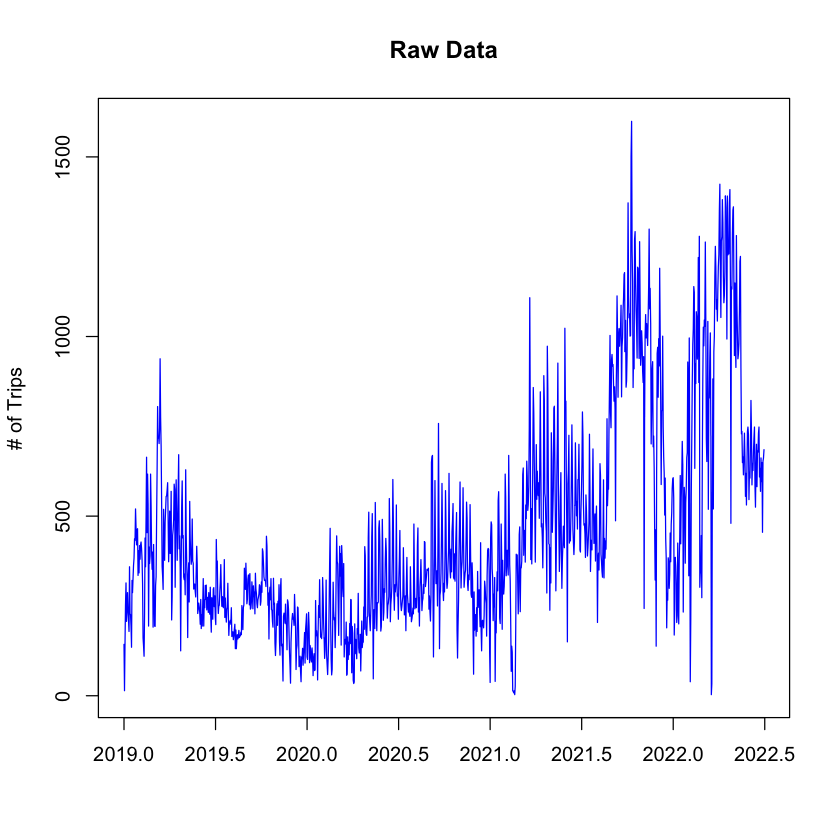

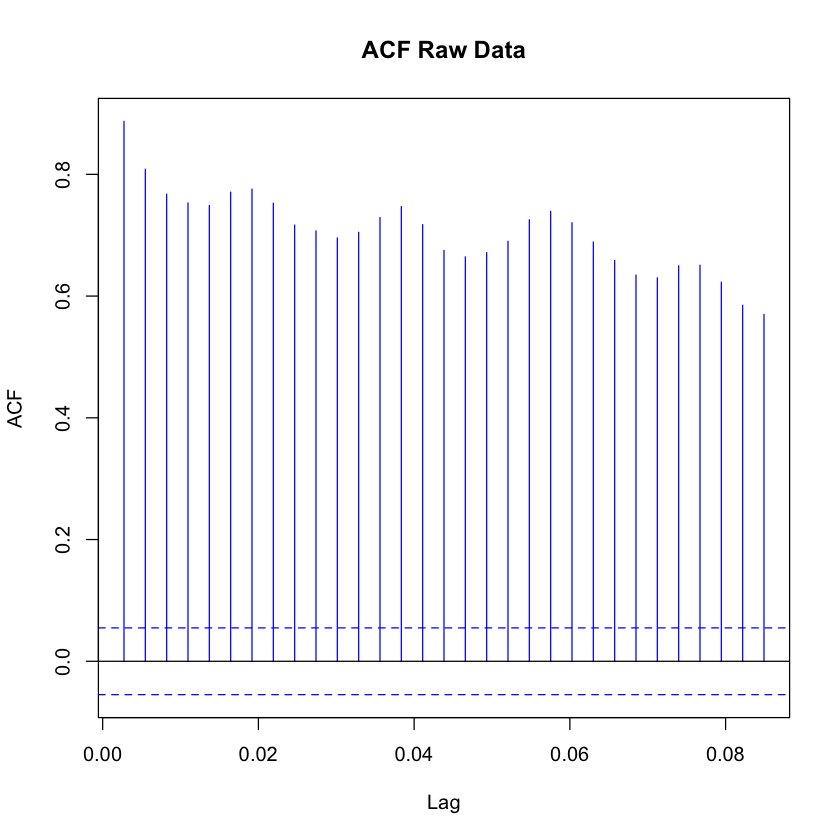

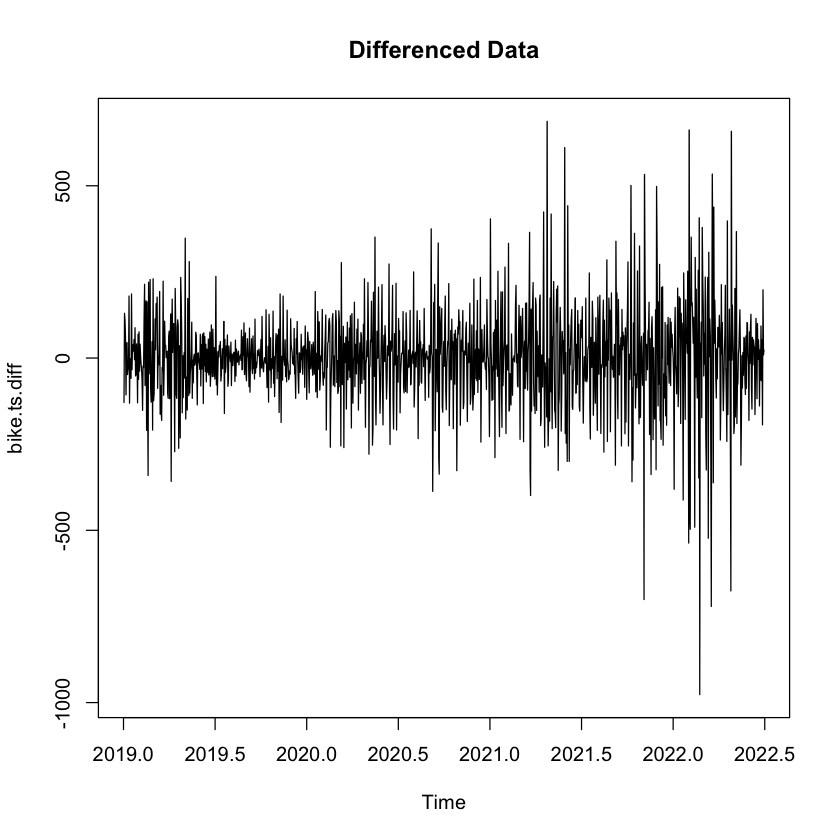

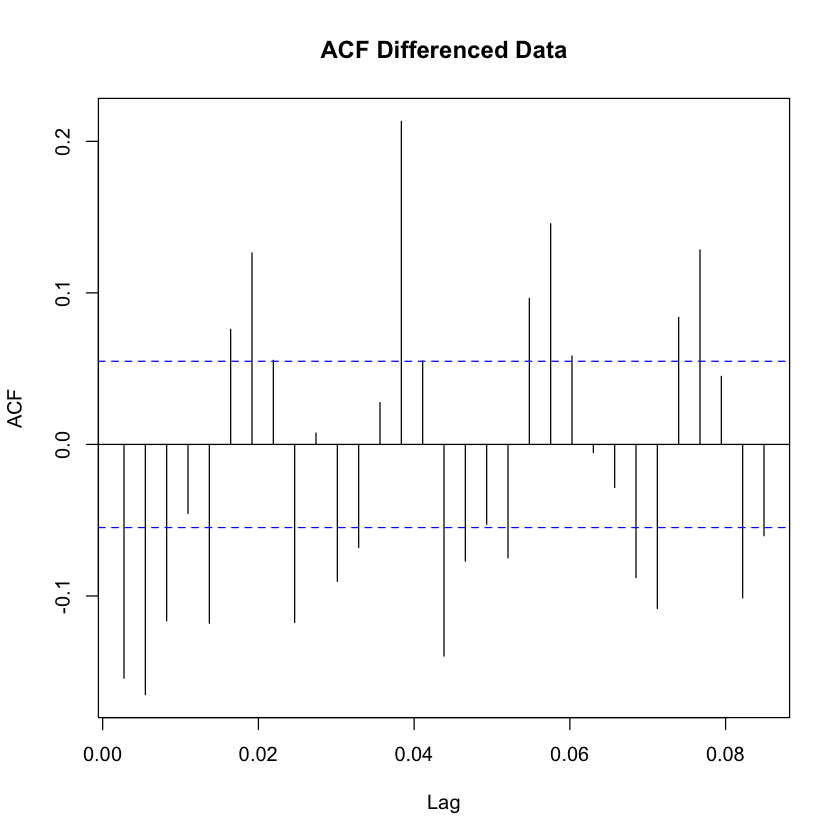

In [32]:
bike.ts <- ts(bike$trips, start = 2019, frequency = 365)
bike.ts.diff <- diff(bike.ts)
bike$diff <- c(0, bike.ts.diff)

#Raw Data
plot.ts(bike.ts, main = "Raw Data", ylab = "# of Trips", xlab="", col="blue")
acf(bike.ts, main = "ACF Raw Data", col="blue")

#First Order DIfference
plot.ts(bike.ts.diff, main = "Differenced Data")
acf(bike.ts.diff, main = "ACF Differenced Data")

*Response: Question 1a*
The raw data exhibits non-stationary behaviour. Each lag is outside the confidence band in the ACF plot indicating the auto correlation is large but decaying over time. There is likely a trend in the data. Further the ACF plot of the raw data shows seasonaility where some lags (0.02, 0.04, 0.06, etc.) are more autocorrelated than others. The features seen in the ACF plot are present in the plot of the raw data where there is an increasing trend with some cyclic behavior.

The differenced data is not stationary because some lags are outside the confidence bands of the ACF plot. The trend seen in the raw data appears to be removed but there is still seasonality present. Further the differenced data reveals larger volitility at as the time series continues. That is, the volitility is larger in 2022 than previous years.

**1b.** Perform a log transformation on the original data. Plot the time series and ACF plots for **both** the regular and first-order differenced log-transformed data. Evaluate the stationarity of the log-transformed data graphically. How does the stationarity of the log-transformed data compare to that of the original data?

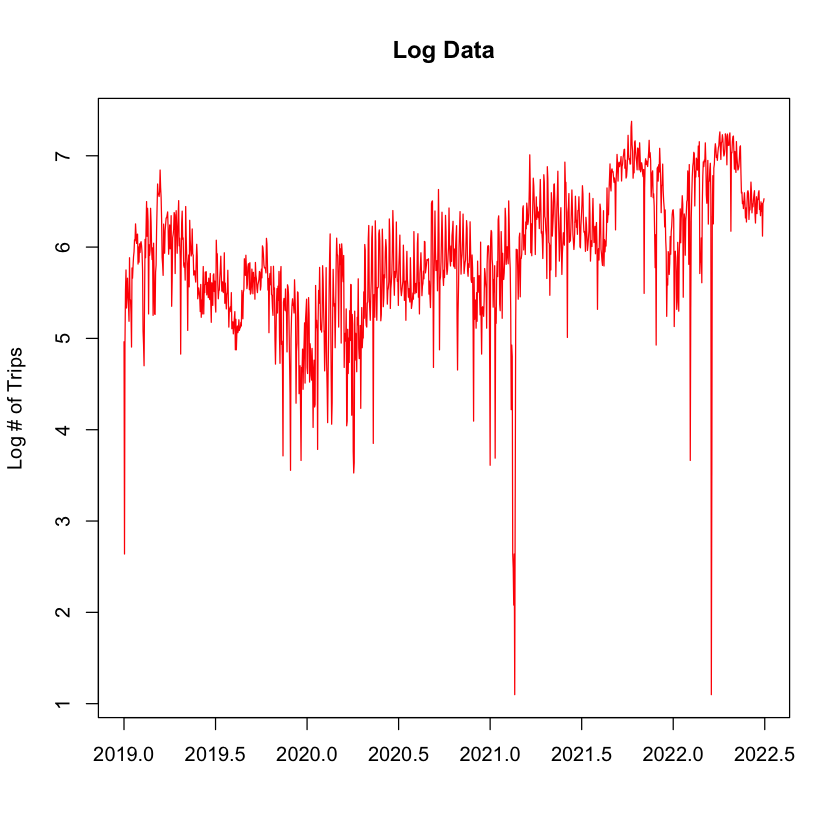

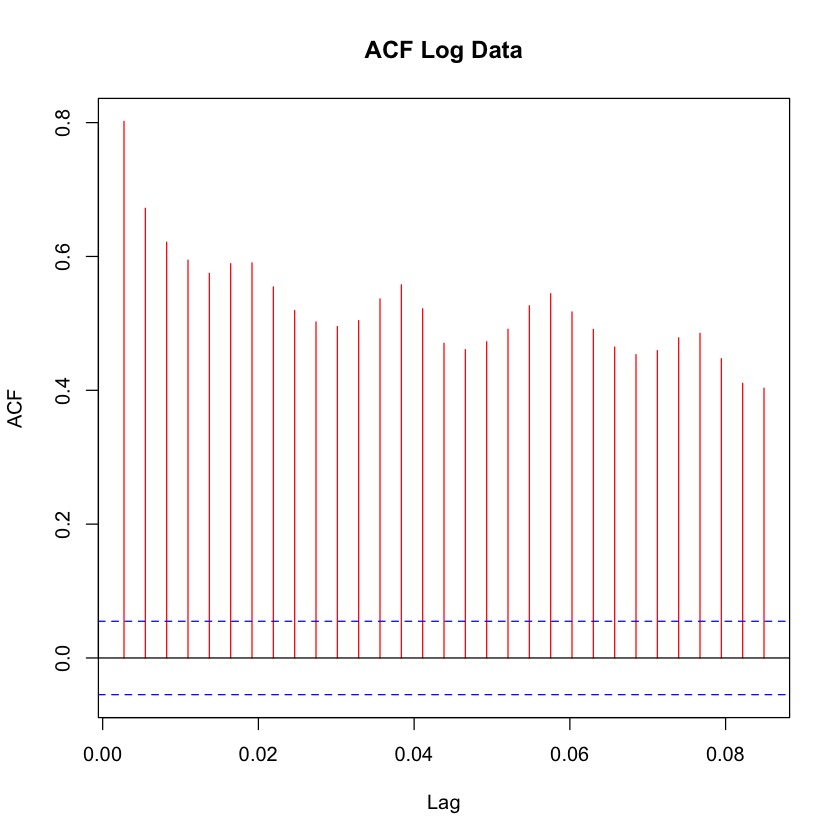

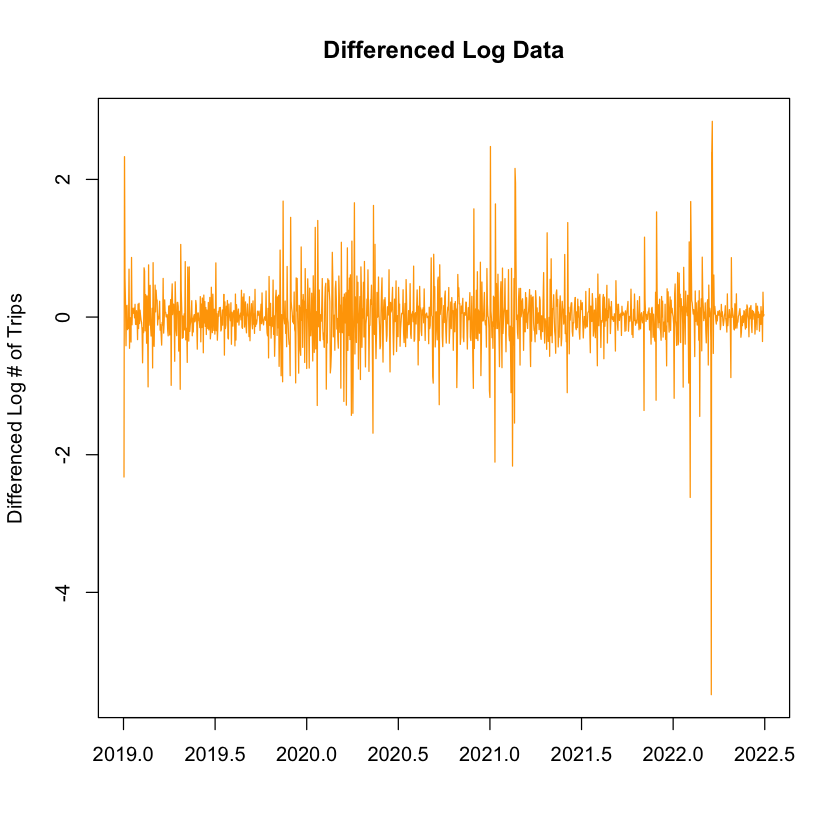

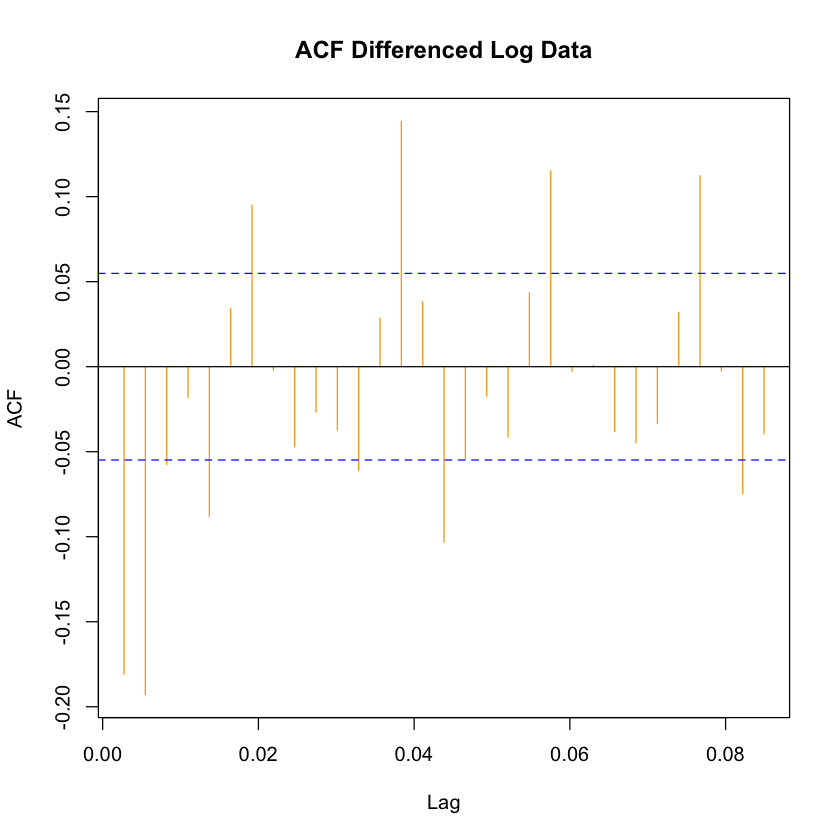

In [26]:
bike$log.trips <- log(bike$trips)
bike.log.ts <- ts(bike$log.trips, start = 2019, frequency = 365)
bike.log.ts.diff <- diff(bike.log.ts)

#Log Data
plot.ts(bike.log.ts, main = "Log Data", ylab = "Log # of Trips", xlab="", col="red")
acf(bike.log.ts, main = "ACF Log Data", col="red")

#Differenced Data
plot.ts(bike.log.ts.diff, main = "Differenced Log Data", ylab = "Differenced Log # of Trips", xlab="", col="orange")
acf(bike.log.ts.diff, main = "ACF Differenced Log Data", col="orange")

*Response: Question 1b*

The stationarity of the log transformed data behaves similar to that of the untransformed data. The log transformed raw data shows the same trend and seasonality with an overall non-stationary process. Similary the log transformed differenced data shows periods of seasonality without trend. Some lags show autocorrelation outside the confidence bands.

**1c.** Based on the plots that you created in 1(a) and 1(b) and what you have learned about time series forecasting, which method do you think would work better for modeling this data: ARIMA or ARMA-GARCH? What advantages and disadvantages might there be to modeling the log-transformed data rather than the original data?

*Response: Question 1c*

ARIMA models the conditional mean while the ARMA-GARCH joint model models the conditional mean and conditional variance. The raw data shows trend, seasonality and heteroskedacity so the ARMA-GARCH join model would be useful in this case. The log transformed reduced heteroskedacity in the data, therefore the ARIMA model for modeling conditional mean would be appropriate.

# Part 2: Model Fitting: Original Data

**2a.** Divide both the original and the first-order differenced untransformed time series into training and test datasets, designating the last two weeks (14 days) as the test datasets and the rest of the data as the training datasets. Fit the following models to the indicated training datasets:

* ARIMA(2,1,3) on the original data, with seasonal orders (1,0,1) to model **weekly** seasonality
* ARMA-GARCH(3,4)x(1,1) on the **differenced** data

Print the summary for both models.

In [52]:
numdaily <- 14
# set up the training and testing data
bike.train <- head(bike, n=length(bike$Date)-numdaily)
bike.test <-tail(bike, n=numdaily)

# ARIMA(2,1,3)
arima1 <- arima(bike.train$trips, order=c(2,1,3), seasonal=c(1,0,1),method="ML")

#ARMA-GARCH
spec = ugarchspec(variance.model=list(garchOrder=c(1,1)),
                 mean.model=list(armaOrder=c(3, 4),
                 include.mean=T), distribution.model="std")
armagarch = ugarchfit(spec, bike.train$diff, solver = 'hybrid')

In [53]:
# Print summaries
arima1
armagarch

Warning message in sqrt(diag(x$var.coef)):
“NaNs produced”



Call:
arima(x = bike.train$trips, order = c(2, 1, 3), seasonal = c(1, 0, 1), method = "ML")

Coefficients:
          ar1     ar2     ma1      ma2      ma3     sar1    sma1
      -0.5911  0.2732  0.1715  -0.7435  -0.1502  -0.1154  0.2235
s.e.      NaN     NaN     NaN   0.0384      NaN      NaN     NaN

sigma^2 estimated as 16984:  log likelihood = -7937.03,  aic = 15888.07


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(3,0,4)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error    t value Pr(>|t|)
mu     -0.250631    0.705382   -0.35531 0.722355
ar1     1.194761    0.012968   92.13159 0.000000
ar2    -0.936888    0.016115  -58.13705 0.000000
ar3    -0.041325    0.013239   -3.12140 0.001800
ma1    -1.609267    0.004044 -397.94359 0.000000
ma2     1.158452    0.000316 3666.14105 0.000000
ma3    -0.055098    0.009075   -6.07143 0.000000
ma4    -0.253182    0.007647  -33.11048 0.000000
omega  78.118487   45.966822    1.69945 0.089234
alpha1  0.080367    0.015968    5.03308 0.000000
beta1   0.918632    0.015054   61.02258 0.000000
shape   5.669074    0.863274    6.56695 0.000000

Robust Standard Errors:
        Estimate  Std. Error  

**2b.** Perform residual analysis on both of the models that you created in 2(a). Evaluate the presence of serial correlation, heteroskedasticity, and normality in each model’s residuals, and interpret the test output, using $\alpha=.05$ as a significance threshold.



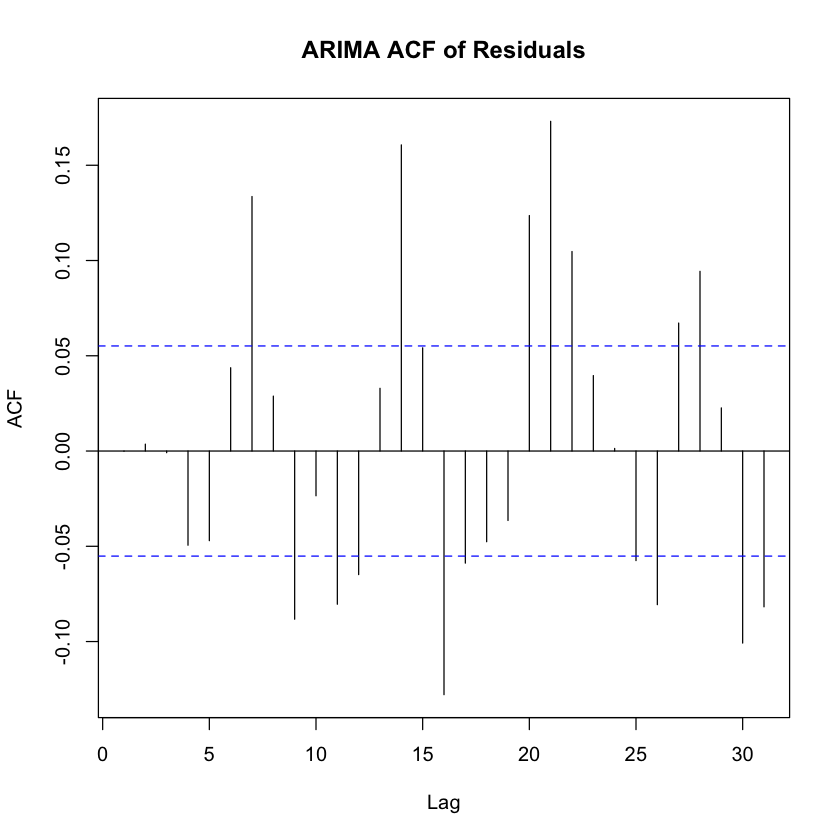


	Box-Ljung test

data:  arima1.residuals
X-squared = 42.746, df = 10, p-value = 5.52e-06



	Box-Ljung test

data:  arima1.residuals^2
X-squared = 156.56, df = 10, p-value < 2.2e-16


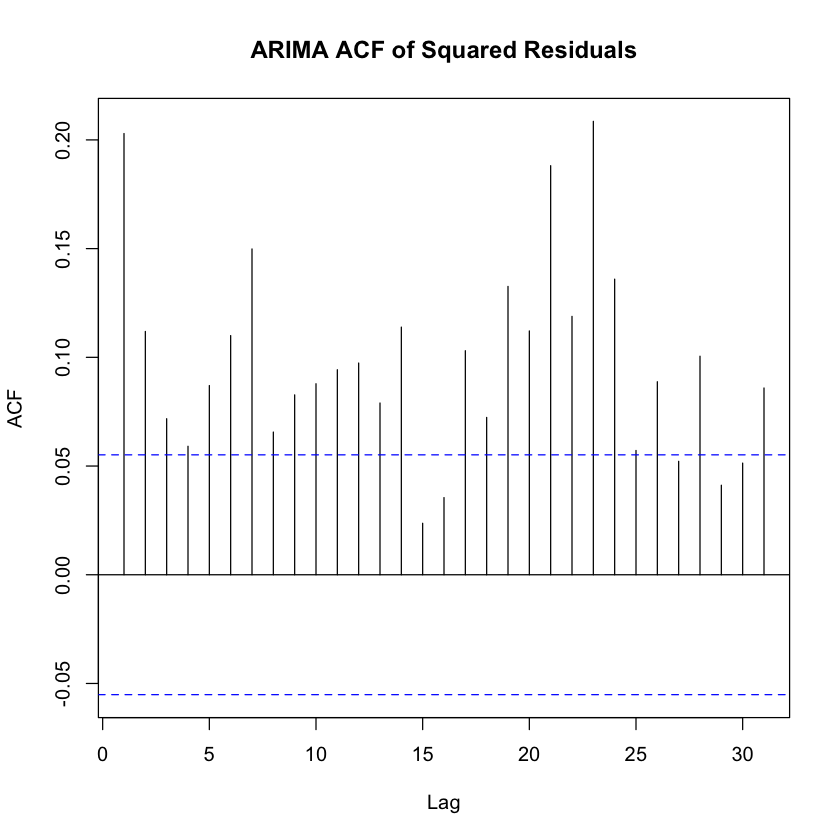

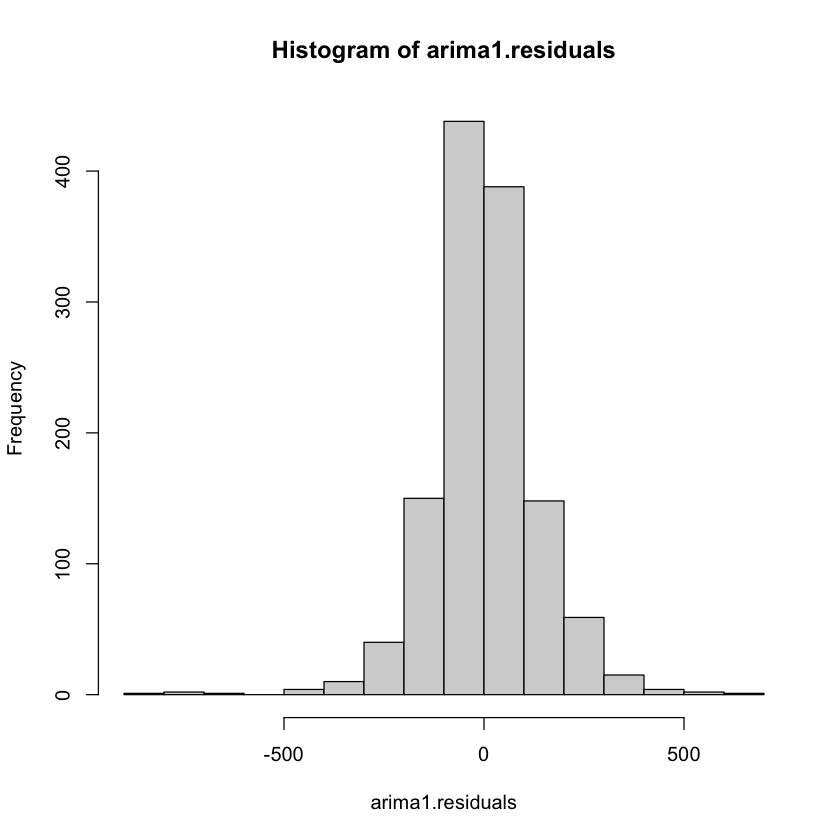

In [54]:
# Raw Data ARIMA Residual Analysis
arima1.residuals = residuals(arima1)
acf(arima1.residuals,main="ARIMA ACF of Residuals")
acf(arima1.residuals^2, main="ARIMA ACF of Squared Residuals")
Box.test(arima1.residuals,lag=10,type='Ljung')
Box.test(arima1.residuals^2,lag=10,type='Ljung')
hist(arima1.residuals)

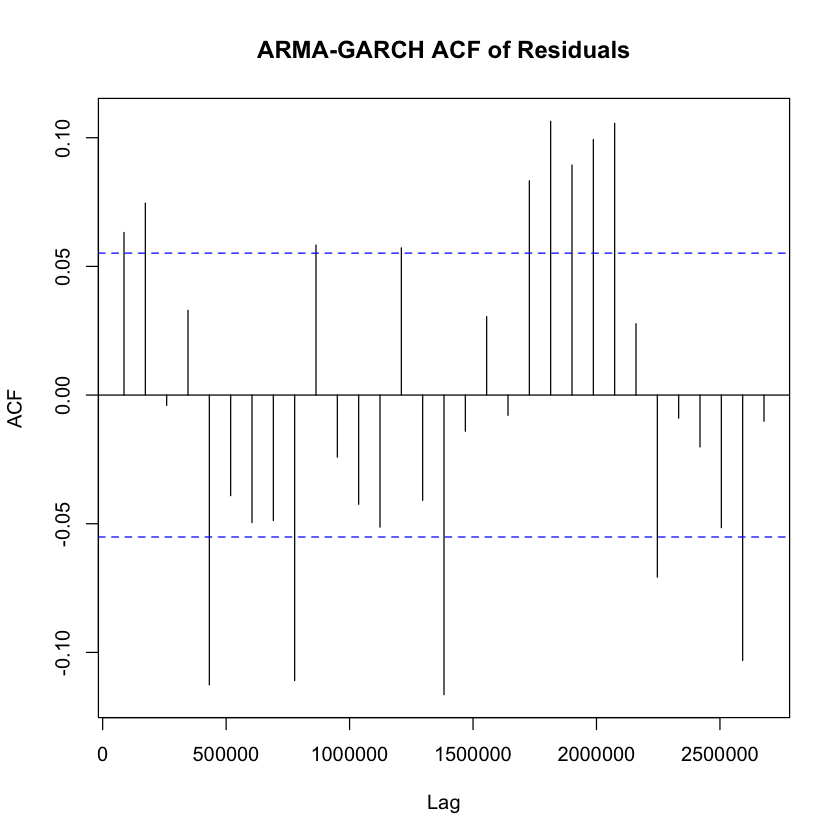


	Box-Ljung test

data:  armagarch.residuals
X-squared = 57.71, df = 10, p-value = 9.802e-09



	Box-Ljung test

data:  armagarch.residuals^2
X-squared = 267.12, df = 10, p-value < 2.2e-16


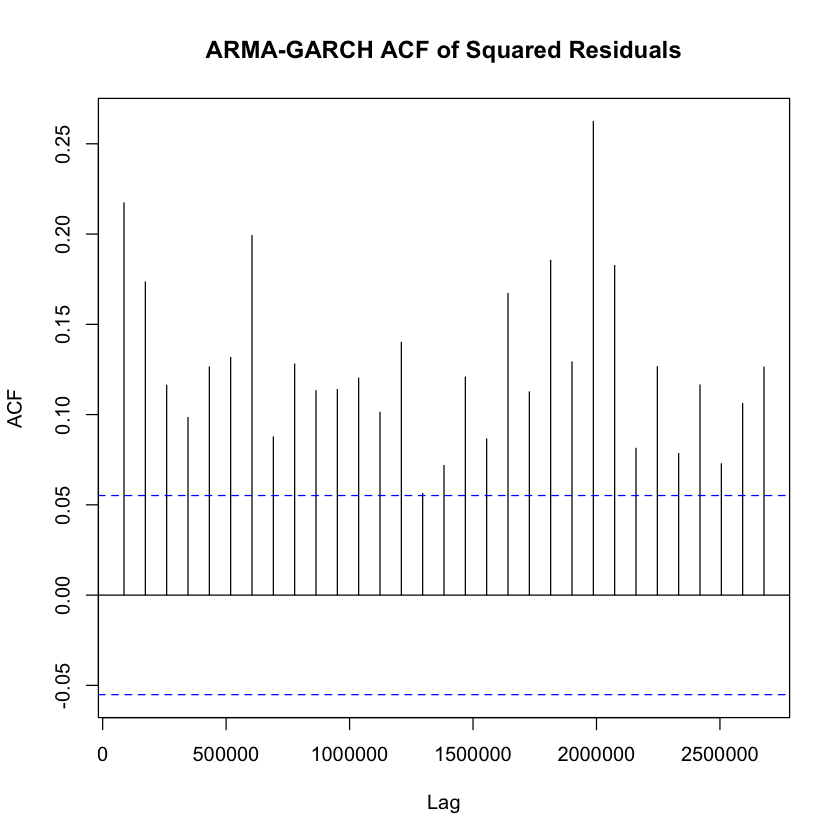

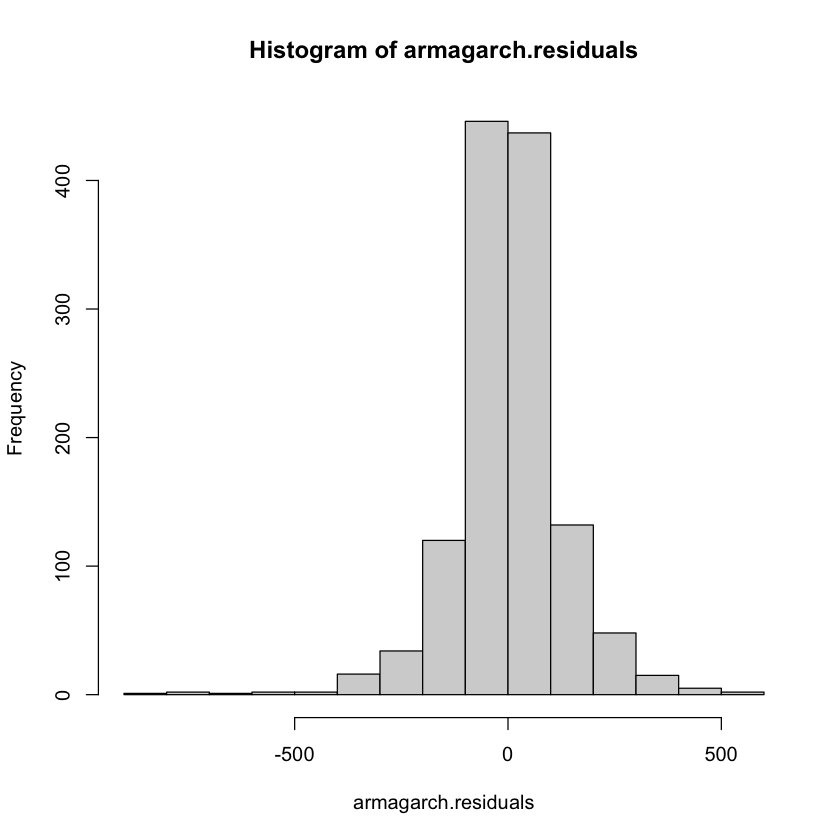

In [55]:
# Differenced Data ARMA-GARCH Residual Analysis
armagarch.residuals = residuals(armagarch)
acf(armagarch.residuals,main="ARMA-GARCH ACF of Residuals")
acf(armagarch.residuals^2, main="ARMA-GARCH ACF of Squared Residuals")
Box.test(armagarch.residuals,lag=10,type='Ljung')
Box.test(armagarch.residuals^2,lag=10,type='Ljung')
hist(armagarch.residuals)

*Response: Question 2b*

- **Serial correlation**: Evaluated using the box-ljung test for serial correlation on the residuals. The p-value is less than 0.05 for both the ARIMA and ARMA-GARCH models indicating that we reject the null hypothesis that the values are not serially correlated. This indicates that the data for both model residuals are serially correlated.
- **Heteroskedasticity**: Evaluated using the the acf and box-ljung test of the squared residuals. Both ARIMA and ARMA-GARCH model squared residuals show autocorrelation outside the ACF confidence and low p-values indicating heteroskedacity exists in the residuals.
- **Normality**: Evaluated visually using the histogram. The residuals of both ARIMA and ARMA-GARCH models are normally distributed about 0.

# Part 3: Model Fitting: Log-Transformed Data

**3a.** Divide the log-transformed data into training and test datasets, following the same designation splits which you used to divide the data in 2(a). Fit the following models on the **undifferenced** log-transformed data:

* ARIMA(4,0,1) with seasonal orders (1,0,1) to model **weekly** seasonality
* ARMA-GARCH(4,4)x(1,1)

Print the summary for both models. Compare the significance of the coefficients in each model to the corresponding model built using the same methods in 2(a).

In [60]:
# ARIMA(2,1,3)
arima.log <- arima(bike.train$log.trips, order=c(4,0,1), seasonal=c(1,0,1),method="ML")

#ARMA-GARCH
spec = ugarchspec(variance.model=list(garchOrder=c(1,1)),
                 mean.model=list(armaOrder=c(4, 4),
                 include.mean=T), distribution.model="std")
armagarch.log = ugarchfit(spec, bike.train$log.trips, solver = 'hybrid')

Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
“possible convergence problem: optim gave code = 1”


In [61]:
arima.log
armagarch.log

Warning message in sqrt(diag(x$var.coef)):
“NaNs produced”



Call:
arima(x = bike.train$log.trips, order = c(4, 0, 1), seasonal = c(1, 0, 1), method = "ML")

Coefficients:
         ar1      ar2     ar3      ar4      ma1    sar1     sma1  intercept
      1.9117  -1.0161  0.1675  -0.0641  -0.8552  0.5243  -0.9346     5.8849
s.e.     NaN   0.1491  0.0676   0.0349      NaN  0.1335   0.0580     0.2088

sigma^2 estimated as 0.1756:  log likelihood = -694.19,  aic = 1404.37


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(4,0,4)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      4.938349    0.148204  33.3213 0.000000
ar1     1.631834    0.007253 225.0015 0.000000
ar2    -0.899763    0.019328 -46.5534 0.000000
ar3    -0.271389    0.067024  -4.0491 0.000051
ar4     0.538739    0.040292  13.3708 0.000000
ma1    -1.110241    0.020905 -53.1083 0.000000
ma2     0.373726    0.037775   9.8936 0.000000
ma3     0.521399    0.050698  10.2844 0.000000
ma4    -0.400689    0.005018 -79.8496 0.000000
omega   0.009127    0.002543   3.5886 0.000332
alpha1  0.275632    0.055597   4.9576 0.000001
beta1   0.723297    0.040060  18.0553 0.000000
shape   3.437733    0.320216  10.7357 0.000000

Robust Standard Errors:
        E

*Response: Question 3a*

- **ARIMA**: The SE of the ARIMA coefficients are larger in the model fitted using the log data than that fitted using the raw data. The AR2, AR3, SAR1, SMA1 coefficients are outside teh 0.05 significance threshold hold in the log model compared to no coefficients outside the confidence level in the raw data ARIMA model.

- **ARMA-GARCH**: Comparitively the ARMA-GARCH model fitted using the log data has all coefficients within the 0.05 confidence level. In the ARMA-GARCH model fitted using the raw data $\mu$ and $\omega$ coefficients were outside the confience threshold.

**3b.** Perform residual analysis on both of the models that you created in 3(a). Evaluate the presence of serial correlation, heteroskedasticity, and normality in each model’s residuals, and interpret the test output, using $\alpha=.05$ as a significance threshold. How do these results compare to those from 2(b)?

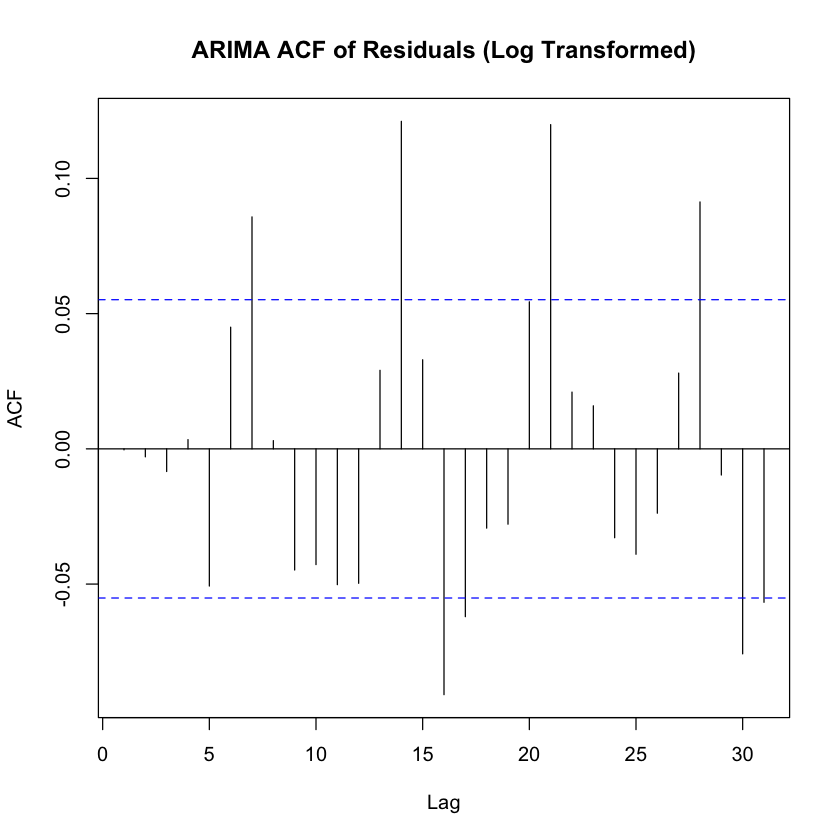


	Box-Ljung test

data:  arima.log.residuals
X-squared = 20.216, df = 10, p-value = 0.02727



	Box-Ljung test

data:  arima.log.residuals^2
X-squared = 18.252, df = 10, p-value = 0.05086


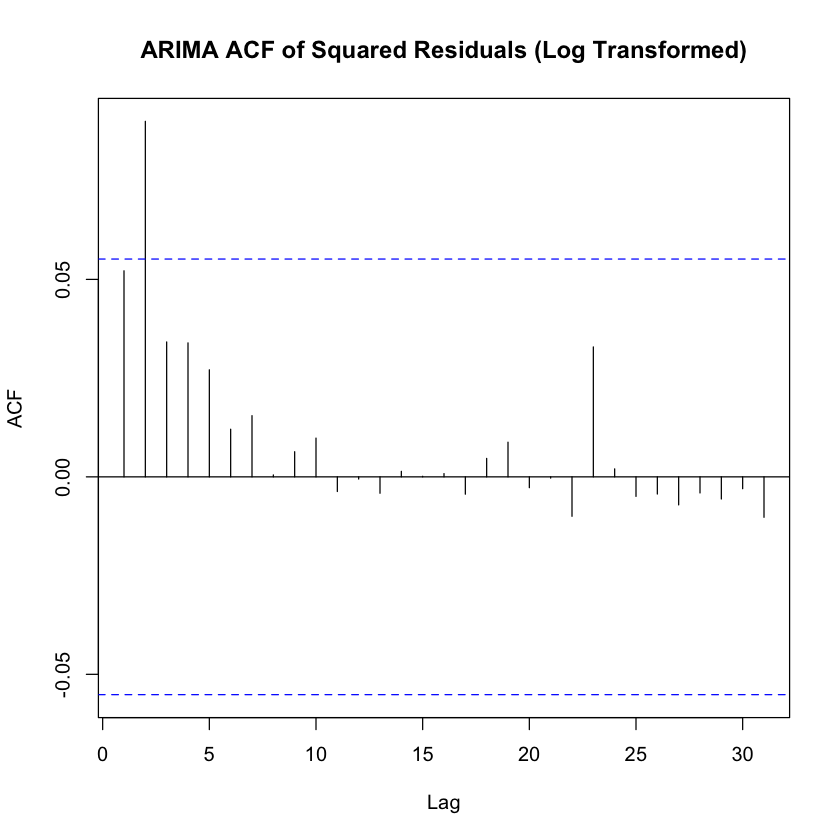

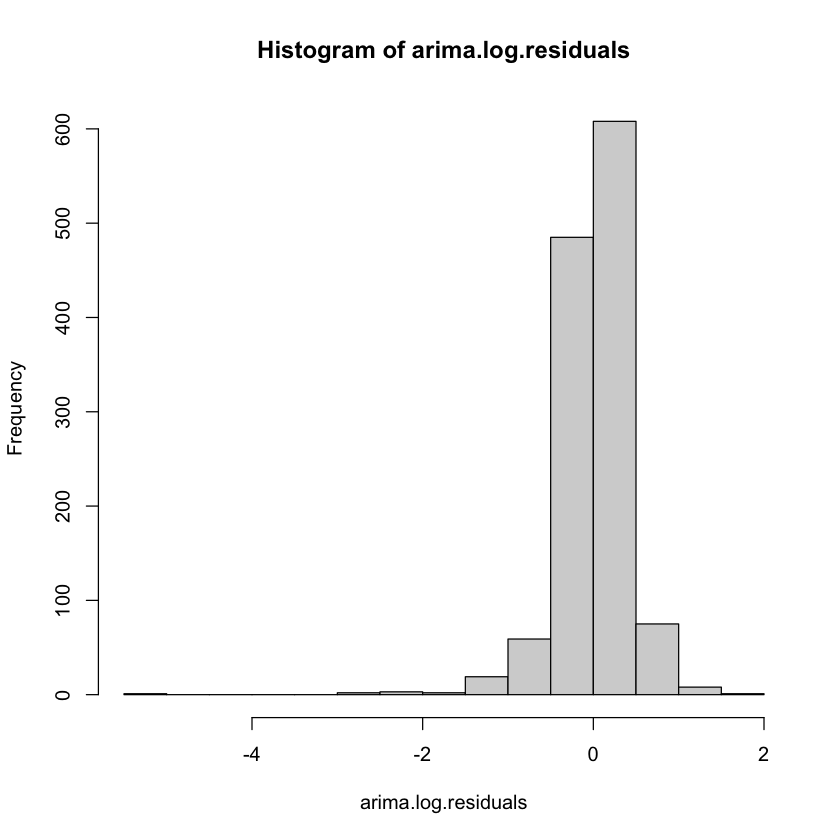

In [62]:
# Log Data ARIMA Residual Analysis
arima.log.residuals = residuals(arima.log)
acf(arima.log.residuals,main="ARIMA ACF of Residuals (Log Transformed)")
acf(arima.log.residuals^2, main="ARIMA ACF of Squared Residuals (Log Transformed)")
Box.test(arima.log.residuals,lag=10,type='Ljung')
Box.test(arima.log.residuals^2,lag=10,type='Ljung')
hist(arima.log.residuals)

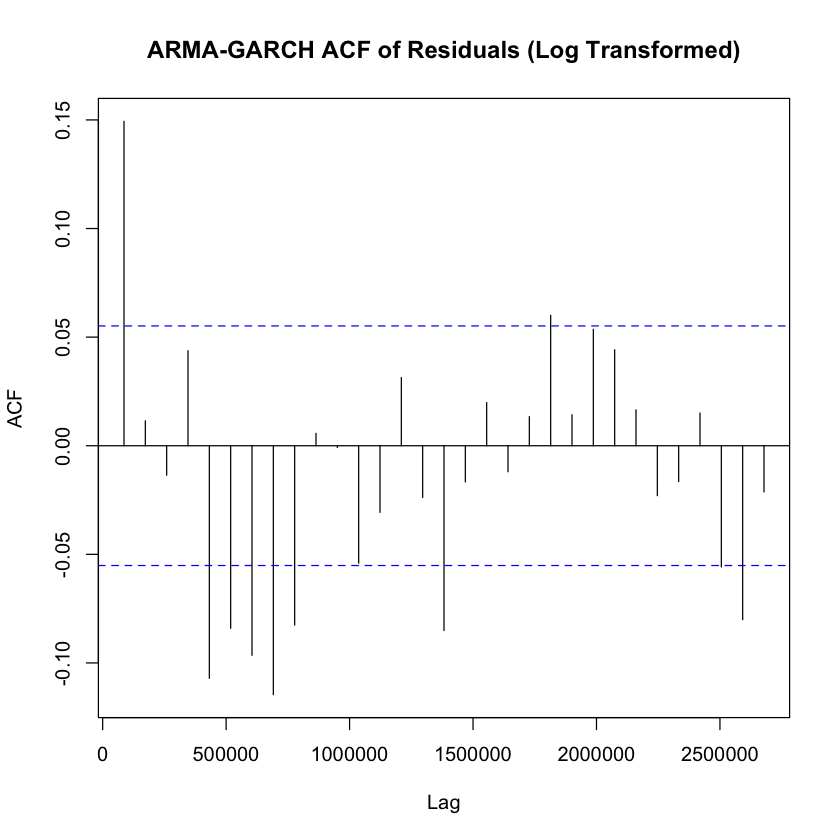


	Box-Ljung test

data:  armagarch.log.residuals
X-squared = 91.88, df = 10, p-value = 2.22e-15



	Box-Ljung test

data:  armagarch.log.residuals^2
X-squared = 48.304, df = 10, p-value = 5.461e-07


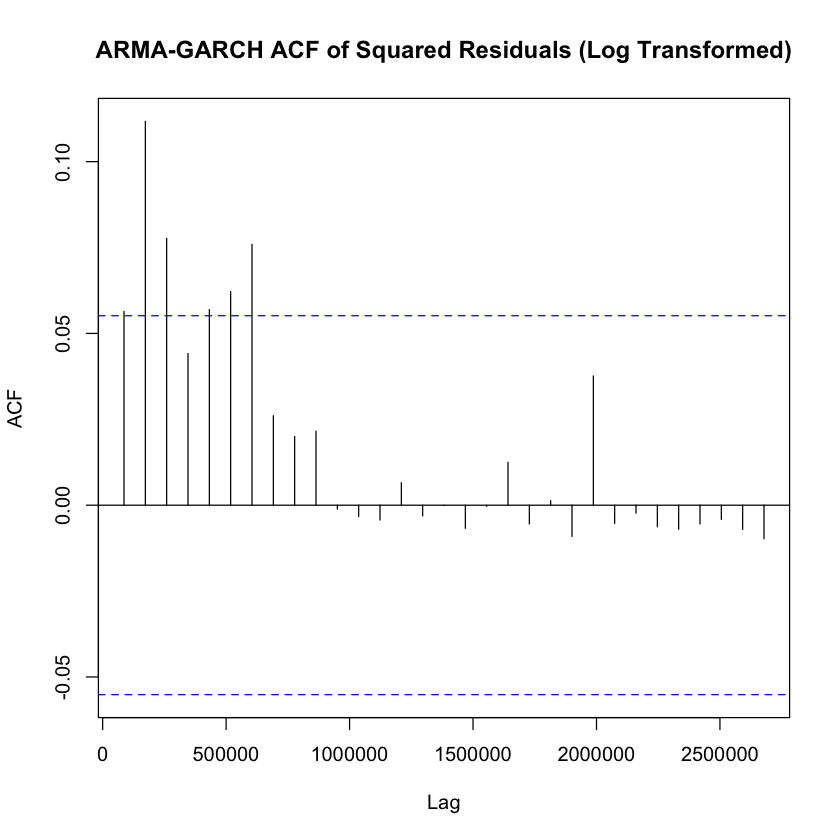

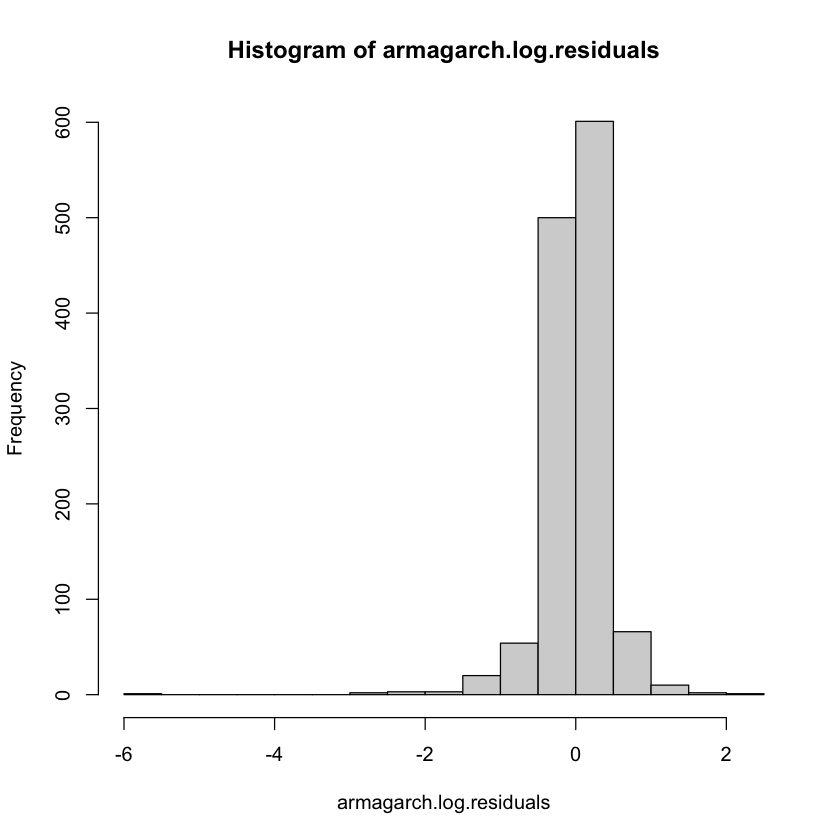

In [63]:
# Log Data ARMA-GARCH Residual Analysis
armagarch.log.residuals = residuals(armagarch.log)
acf(armagarch.log.residuals,main="ARMA-GARCH ACF of Residuals (Log Transformed)")
acf(armagarch.log.residuals^2, main="ARMA-GARCH ACF of Squared Residuals (Log Transformed)")
Box.test(armagarch.log.residuals,lag=10,type='Ljung')
Box.test(armagarch.log.residuals^2,lag=10,type='Ljung')
hist(armagarch.log.residuals)

*Response: Question 3b*

- **Serial correlation**: Evaluated using the box-ljung test for serial correlation on the residuals. The p-value is less than 0.05 for both the ARIMA and ARMA-GARCH models indicating that we reject the null hypothesis that the values are not serially correlated. This indicates that the data for both model residuals are serially correlated. This is the same result as that for the ARIMA and ARMA-GARCH models in 3a. The box-ljung test for residuals in significant higher for the ARIMA model (0.02); however it is still lower than the threshold value of 0.05.
- **Heteroskedasticity**: Evaluated using the the acf and box-ljung test of the squared residuals. The ARMA-GARCH model shows a score less than 0.05 indicating we reject the null hypothesis that there is not serial correlation in the residuals indicating hetereoskedacity exists. However, the ARIMA model score is greater than 0.05 indicating we fail to reject the null hypothesis that there is no serial correlation. Further the ACF plot of the squared residuals for the ARIMA model resembles white noise which visually corrobrates the box-ljung result.
- **Normality**: Evaluated visually using the histogram. The residuals of both ARIMA and ARMA-GARCH models are normally distributed about 0. However both models show a large outlier. 

# Part 4: Forecasting

**4a.** Apply the models from Parts 2 and 3 and forecast the number of daily bikeshare trips for the next two weeks. Plot the forecasts for each model on the original time series and compare the forecasts to the actual values. (You do not need to plot the confidence intervals.) *Hint: Don't forget to transform the predicted values!*

In [98]:
fore.arima.raw = predict(arima1, n.ahead = 14) 
fore.armagarch.diff = ugarchforecast(armagarch, n.ahead=14)
fore.arima.log = predict(arima.log, n.ahead = 14) 
fore.armagarch.log = ugarchforecast(armagarch.log, n.ahead=14)

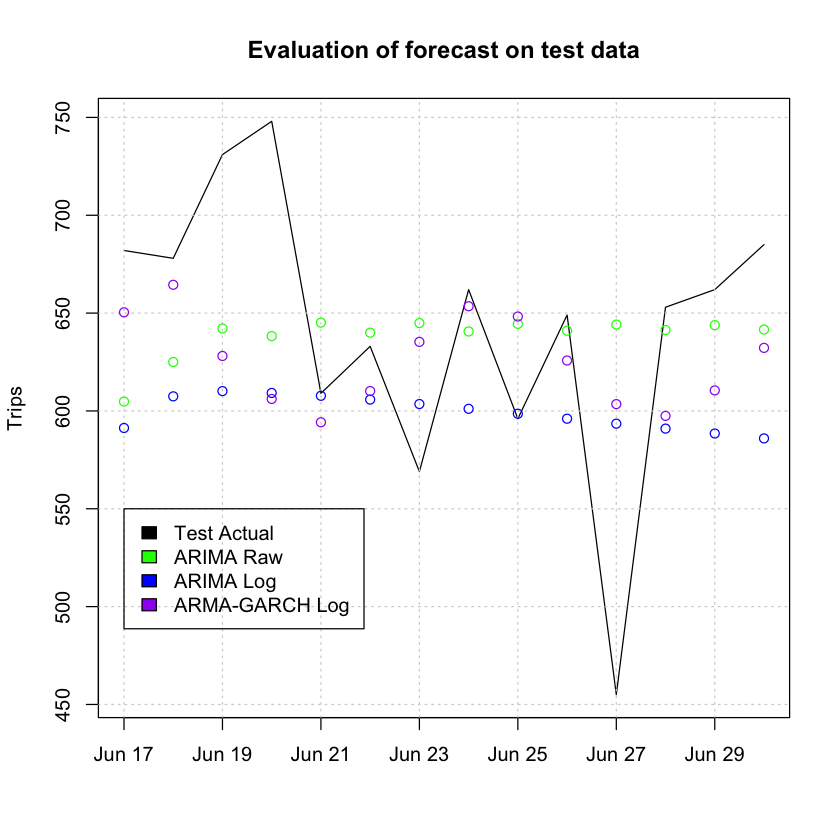

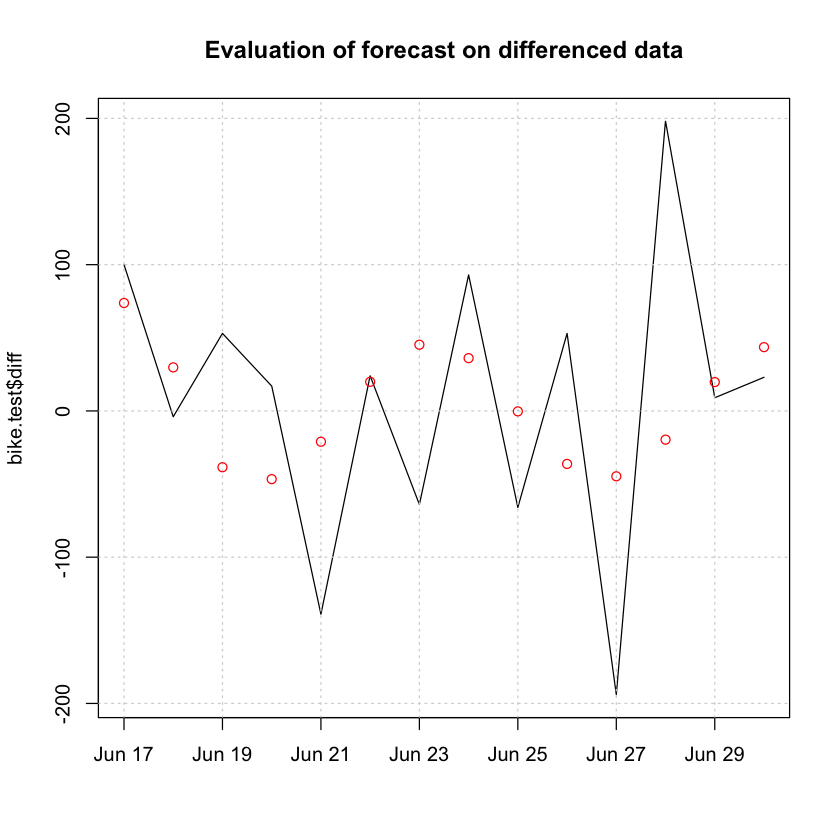

In [104]:
bike.test$date <- date(bike.test$date)
plot(x=bike.test$date, y=bike.test$trips, main="Evaluation of forecast on test data",ylab="Trips", type="l", xlab="")
grid()
points(x=bike.test$date, y=fore.arima.raw$pred, col="green")
points(x=bike.test$date, y=exp(fore.arima.log$pred), col="blue")
points(x=bike.test$date, y=exp(fore.armagarch.log@forecast$seriesFor), col="purple")
legend(date("2022-06-17"), 550,legend=c("Test Actual", "ARIMA Raw", "ARIMA Log", "ARMA-GARCH Log"), 
       fill = c("black", "green", "blue", "purple"))

plot(x=bike.test$date, y=bike.test$diff, main="Evaluation of forecast on differenced data", type="l", xlab="")
grid()
points(x=bike.test$date, y=fore.armagarch.diff@forecast$seriesFor, col="red")

**4b.** Calculate MAPE and PM for the four models. Compare the accuracy between models.



In [116]:
#MAPE
MAPE.ARIMA.Raw = mean(abs(fore.arima.raw$pred-bike.test$trips)/bike.test$trips)
MAPE.ARMAGARCH.diff = mean(abs(fore.armagarch.diff@forecast$seriesFor-bike.test$diff)/bike.test$diff)
MAPE.ARIMA.Log = mean(abs(exp(fore.arima.log$pred)-bike.test$trips)/bike.test$trips)
MAPE.ARMAGARCH.Log = mean(abs(exp(fore.armagarch.log@forecast$seriesFor)-bike.test$trips)/bike.test$trips)

#PM
PM.ARIMA.Raw = sum((fore.arima.raw$pred-bike.test$trips)^2)/sum((bike.test$trips-mean(bike.test$trips))^2)
PM.ARMAGARCH.diff = sum((fore.armagarch.diff@forecast$seriesFor-bike.test$diff)^2)/sum((bike.test$diff-mean(bike.test$diff))^2)
PM.ARIMA.Log = sum((exp(fore.arima.log$pred)-bike.test$trips)^2)/sum((bike.test$trips-mean(bike.test$trips))^2)
PM.ARMAGARCH.Log = sum((exp(fore.armagarch.log@forecast$seriesFor)-bike.test$trips)^2)/sum((bike.test$trips-mean(bike.test$trips))^2)

paste("MAPE ARIMA Raw:", MAPE.ARIMA.Raw)
paste("MAPE ARMA-GARCH Diff", MAPE.ARMAGARCH.diff)
paste("MAPE ARIMA Log:", MAPE.ARIMA.Log)
paste("MAPE ARMA-GARCH log", MAPE.ARMAGARCH.Log)

paste("PM ARIMA Raw:", PM.ARIMA.Raw)
paste("PM ARMA-GARCH Diff", PM.ARMAGARCH.diff)
paste("PM ARIMA Log:", PM.ARIMA.Log)
paste("PM ARMA-GARCH log", PM.ARMAGARCH.Log)


[1] "MAPE ARIMA Raw: 0.0938391980759125"

[1] "MAPE ARMA-GARCH Diff -0.0985108030515527"

[1] "MAPE ARIMA Log: 0.109046638448681"

[1] "MAPE ARMA-GARCH log 0.0911511207910713"

[1] "PM ARIMA Raw: 1.12296316792171"

[1] "PM ARMA-GARCH Diff 0.970775208601118"

[1] "PM ARIMA Log: 1.3707518647836"

[1] "PM ARMA-GARCH log 1.03696822969931"

*Response: Question 4b*

The absolute value of the MAPE values for all models is simlar, ~0.1; however the precision metric shows the ARMA-GARCH models to be slightly more accurate than the ARIMA models. The lowest PM value (most accurate) is that of the ARMA-GARCH model on the differenced data, followed by the ARMA-GARCH model on teh log data. This indicates the predictions from these models are the closest to the actuals.

# Part 5: Reflection

Compare and contrast the performance of the four models that you created with your expectations and assumptions that you recorded in 1(c). Which methods and transformations (or lack thereof) performed best? Based on your exploration of the data, why do you think that the best-performing model(s) were a better fit for the data? What insights can we learn about data transformation and model selection from this analysis?

*Response: Question 5*

All models performed well in predicting the test data however the ARMA-GARCH followed the data more closely than the ARIMA models. As stated in data discovery the 2022 data was the most volitile with large spikes in the number of trips on a daily basis. In order to account for the changing variance, an ARMA-GARCH joint model was appropriate to model the volitility in the data. The ARMA-GARCH model's ability to do this is best shown in the figure showing the comparison in predictions of the ARIMA and ARMA-GARCH models. The ARMA-GARCH model more closely follows the spikes in the data while the ARIMA models predicitons are relatively constant and unable to explain the volitility.

The ARMA-GARCH model was the best-performing model becasue of it's ability to model both the conditional mean and conditional variance. Further, the differenced ARMA-GARCH model showed this best results. This is likely because differencing the data removed the overall trend. The trend in the data likely caused additional prediciton error in the ARMA-GARCH log-transformed model causing the PM to be higher.

Data transformation is very important in model selection. Removing trend through differencing is a powerful transformation that can improve overall model fit. Further reducing heteroskedacity with a log-transformation can help to improve the model's fit.